# Titanic - Survival Prediction (Multiple Models)

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.utils import shuffle
import xgboost

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

# View head
#data.head()

C:\Users\Jagan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Notice that 'Name' column contains strings that has 'Title' such as 'Mr', 'Master' and 'Dona'. Let's use regular expressions to extract the 'Title'.

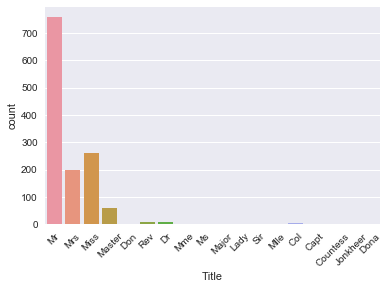

In [2]:
# Extract Title from Name, store in column and plot barplot
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

There are several titles and it makes sense to put them in fewer buckets.

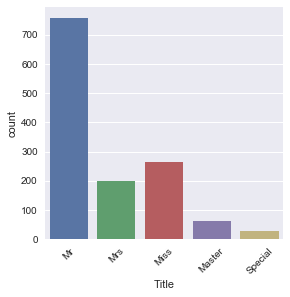

In [3]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.factorplot(x='Title', kind='count',data=data);
plt.xticks(rotation=45);

Check out the data again and make sure that we have a 'Title' column.

In [4]:
# View head of data
#data.tail()

### Feature Engineering: 
There are several NaNs (missing values) in the 'Cabin' column. It is reasonable to presume that those with NaNs in the 'Cabin' column didn't have a cabin, which may have something to do with 'Survival'. So now let's create a new column that encodes this information.

In [14]:
# Did they have a Cabin?
cabin = ~data.Cabin.isnull().values == 1
print(cabin)
#data['Has_Cabin'] = 

# View head of data
data.head()

[False  True False ..., False False False]


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Let's drop columns that contain no more useful (as of now) information, i.e. 'Cabin', 'Name', 'PassengerId' and 'Ticket'.

In [ ]:
# Drop columns and view head
data.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
#data.head()

### Dealing with missing values:

Let's figure out if there are any missing values. If yes, then we need to do something about it.

In [ ]:
data.info()

Look's like there is some missing data in 'Age', 'Fare' and 'Embarked'. Let's impute these values:

In [ ]:
# Impute missing values for Age, Fare, Embarked
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())
data['Embarked'] = data['Embarked'].fillna('S')
data.info()

In [ ]:
data.head()

### Binning numerical data:

Use the `pandas` function `qcut` to bin your numerical data.

In [ ]:
# Binning numerical columns
data['CatAge'] = pd.qcut(data.Age, q=10, labels=False, duplicates='drop' )
data['CatFare']= pd.qcut(data.Fare, q=10, labels=False)
#data.head()

'Age' and 'Fare' columns can now be dropped.

In [ ]:
data = data.drop(['Age', 'Fare'], axis=1)
#data.head()

### Combining features - Family:

In [ ]:
# Create column of number of Family members onboard
data['Fam_Size'] = data.SibSp + data.Parch

In [ ]:
# Drop columns
data = data.drop(['SibSp','Parch'], axis=1)
data.head()

### Transforming all 'categorical' variables into 'numerical' values:

In [ ]:
# Transform into binary variables
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

### Building models: 

Now that all the necessary feature engineering has been completed, we'll begin with building models. As before, first we'll split our `data` back into training and test sets; then transform them into arrays.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import linear_model, tree, ensemble, discriminant_analysis, svm, neighbors, neural_network

In [ ]:
# Split the data into train, test and cross-val sets and transform into arrays for scikit
train = data_dum.iloc[:891].values
test = data_dum.iloc[891:].values
y = survived_train.values

train[:5]

We're now going to build a suite of classifier models and train them on the feature-engineered dataset. To select the optimum  hyperparameters, we'll use a variation on test-train split called cross validation.

For more on cross validation, check out: ***http://scikit-learn.org/stable/modules/cross_validation.html

#### Helper Functions:

In [ ]:
def scale(train,test):
    # Steps : 
    # 1) Fit only on training data - don't cheat
    # 2) Apply transformation on both training and test data
    scaler = StandardScaler(); scaler.fit(train)  
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled

#### Global Tuning Parameters:

In [ ]:
loss = ['hinge', 'log', 'squared_hinge', 'perceptron']
penalty = ['l1', 'l2']
alpha = 10.0**-np.arange(1,7)
C = 10.0**np.arange(-4,4,0.1)
estimators = np.arange(10,21)
dep = np.arange(2,15)
solver = ['lsqr','eigen']
reg_param = np.arange(0.0,1.0,.01)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = np.arange(2,6)

### Linear Methods:

#### Logistic Regression:

In [ ]:
def Logit_Regression(train,test,y):
    # Fit the model
    clf = linear_model.LogisticRegressionCV(cv=5)
    clf.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameter: {}".format({'C' :clf.C_ }))
    print("Best score is {}".format(np.median(clf.scores_[1])))
    
    # Save the results
    y_pred_log_reg = clf.predict(test)
    df_test['Survived'] = y_pred_log_reg
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/logistic_regression.csv', index=False)
    return y_pred_log_reg

In [ ]:
y_pred_log = Logit_Regression(train,test,y)

#### SGD Classification:

In [ ]:
def SGD_Classification(train,test,y):
    # Scale the data
    train_scaled, test_scaled = scale(train, test)
        
    # Fit the model
    tuning_params = {'loss': loss, 'alpha': alpha}
    clf = linear_model.SGDClassifier(max_iter=5,tol=None,shuffle=True)
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train_scaled, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    # Save the results
    y_pred_sgd = clf_cv.predict(test_scaled)
    df_test['Survived'] = y_pred_sgd
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/stochastic_gradient_descent.csv', index=False)
    return y_pred_sgd

In [ ]:
y_pred_sgd = SGD_Classification(train,test,y)

#### Perceptron:

In [ ]:
def Perceptron_Classification(train,test,y):
    # Fit the model
    tuning_params = {'penalty': penalty, 'alpha': alpha}
    clf = linear_model.Perceptron(max_iter=10,tol=None)
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_per = clf_cv.predict(test)
    df_test['Survived'] = y_pred_per
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/perceptron.csv', index=False)
    return y_pred_per

In [ ]:
y_pred_per = Perceptron_Classification(train,test,y)

### Discriminant Analysis:

#### LDA:

In [ ]:
def LDA_Classification(train,test,y):
    # Fit the model
    tuning_params = {'solver' : solver}
    clf = discriminant_analysis.LinearDiscriminantAnalysis(shrinkage='auto')
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_lda = clf_cv.predict(test)
    df_test['Survived'] = y_pred_lda
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/lda.csv', index=False)
    return y_pred_lda

In [ ]:
y_pred_lda = LDA_Classification(train,test,y)

#### QDA:

In [ ]:
def QDA_Classification(train,test,y):
    # Fit the model
    tuning_params = {'reg_param' : reg_param }
    clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
     # Save the results
    y_pred_qda = clf_cv.predict(test)
    df_test['Survived'] = y_pred_qda
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/qda.csv', index=False)
    return y_pred_qda

In [ ]:
y_pred_qda = QDA_Classification(train,test,y)

### Support Vector Machines:

In [ ]:
def SVM_Classification(train,test,y):
    # Scale the data
    train_scaled, test_scaled = scale(train, test)
    
    # Fit the model
    tuning_params = {'kernel': kernel, 'degree' : degree}
    clf = svm.SVC(C=20,class_weight='balanced')
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train_scaled, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_svm = clf_cv.predict(test_scaled)
    df_test['Survived'] =  y_pred_svm
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/svm.csv', index=False)
    return y_pred_svm

In [ ]:
y_pred_svm = SVM_Classification(train,test,y)

### Decision Trees:

In [ ]:
def Decision_Trees_Classification(train,test,y):
    # Fit the model
    tuning_params = {'max_depth' : dep}
    clf = tree.DecisionTreeClassifier(min_samples_split=4,min_samples_leaf=5,class_weight='balanced')
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_dt = clf_cv.predict(test)
    df_test['Survived'] = y_pred_dt
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/decision_tree.csv', index=False)
    return y_pred_dt

In [ ]:
y_pred_dt = Decision_Trees_Classification(train,test,y)

### Ensemble Methods:

#### Bagging Meta-estimator:

In [ ]:
def Bagging_Meta_Classification(train,test,y):
    # Fit the model
    base_estimator = [linear_model.LogisticRegression(C=167),
                      linear_model.SGDClassifier(loss='log',alpha=0.01,max_iter=5,tol=None,shuffle=True),
                      discriminant_analysis.LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto'),
                      discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param=0.03),
                      svm.SVC(C=20,kernel='poly',degree=3,class_weight='balanced')] # This might take some time
    tuning_params = {'n_estimators' : estimators}
    clf = ensemble.BaggingClassifier(base_estimator[4])
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_bm = clf_cv.predict(test)
    df_test['Survived'] = y_pred_bm
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/bagging_meta_estimator.csv', index=False)
    return y_pred_bm

In [ ]:
y_pred_bm = Bagging_Meta_Classification(train,test,y)

#### Random Forests:

In [ ]:
def Random_Trees_Classification(train,test,y):
    # Fit the model
    tuning_params = {'n_estimators' : estimators, 'max_depth' : dep}
    clf = ensemble.RandomForestClassifier(class_weight='balanced')
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_rf = clf_cv.predict(test)
    df_test['Survived'] = y_pred_rf
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/random_forest.csv', index=False)
    return y_pred_rf

In [ ]:
y_pred_rf = Random_Trees_Classification(train,test,y)

#### Extremely Randomized Trees:

In [ ]:
def Extremely_Randomized_Trees_Classification(train,test,y):
    # Fit the model
    tuning_params = {'n_estimators' : estimators, 'max_depth' : dep}
    clf = ensemble.ExtraTreesClassifier(class_weight='balanced')
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_ert = clf_cv.predict(test)
    df_test['Survived'] = y_pred_ert
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/extremely_randomized_trees.csv', index=False)
    return y_pred_ert

In [ ]:
y_pred_ert = Extremely_Randomized_Trees_Classification(train,test,y)

#### Adaboost:

In [ ]:
def Adaboost_Classification(train,test,y):
    # Fit the model
    base_estimator = [linear_model.LogisticRegression(C=167),
                      svm.SVC(C=20,kernel='poly',degree=3,class_weight='balanced'),
                      tree.DecisionTreeClassifier(max_depth=5,min_samples_split=4,min_samples_leaf=5,class_weight='balanced')]
    learning_rate = 10.0**np.arange(-3,0,.5)
    tuning_params = {'base_estimator' : base_estimator, 'learning_rate' : learning_rate}
    clf = ensemble.AdaBoostClassifier(n_estimators=100,algorithm='SAMME')
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_ada = clf_cv.predict(test)
    df_test['Survived'] = y_pred_ada
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/ada_boost.csv', index=False)
    return y_pred_ada

In [ ]:
y_pred_ada = Adaboost_Classification(train,test,y)

#### Gradient Tree Boosting:

In [ ]:
def GTB_Classification(train,test,y):
    # Fit the model
    learning_rate = 10.0**np.arange(-3,0,.5)
    tuning_params = {'learning_rate' : learning_rate}
    clf = ensemble.GradientBoostingClassifier(n_estimators=200)
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_gtb = clf_cv.predict(test)
    df_test['Survived'] = y_pred_gtb
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/gtb.csv', index=False)
    return y_pred_gtb

In [ ]:
y_pred_gtb = GTB_Classification(train,test,y)

#### Voting Classifier:

In [ ]:
def Voting_Classification(train,test,y):
    # Fit the model
    list_of_estimators = [('log', linear_model.LogisticRegression(C=167)),
                      ('sgd', linear_model.SGDClassifier(loss='log',alpha=0.01,max_iter=5,tol=None,shuffle=True)),
                      ('lda', discriminant_analysis.LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')),
                      ('qda', discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param=0.03)),
                      ('svm', svm.SVC(C=20,kernel='poly',degree=3,probability=True,class_weight='balanced')),
                      ('rf',  ensemble.RandomForestClassifier(n_estimators=15,max_depth=6,class_weight='balanced')),
                      ('gtb', ensemble.GradientBoostingClassifier(n_estimators=200,learning_rate=0.01))]
    voting = ['hard','soft']
    
    tuning_params = {'voting' : voting}
    clf = ensemble.VotingClassifier(estimators=list_of_estimators)
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=5)
    clf_cv.fit(train, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_vc = clf_cv.predict(test)
    df_test['Survived'] = y_pred_vc
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/vc.csv', index=False)
    return y_pred_vc

In [ ]:
y_pred_vc = Voting_Classification(train,test,y)

### Neural Networks:

In [ ]:
def NN_Classification(train,test,y):
     # Scale the data
    train_scaled, test_scaled = scale(train, test)
    
    # Fit the model
    tuning_params = {'alpha' : 10.0**np.arange(-7,0,.01)}
    
    clf = neural_network.MLPClassifier(solver='lbfgs',hidden_layer_sizes=(20,40,10,5),learning_rate='adaptive', random_state=7)
    clf_cv = GridSearchCV(clf, param_grid=tuning_params, n_jobs=-1, cv=2)
    clf_cv.fit(train_scaled, y)
    
    # Print the tuned parameter and score
    print("Tuned Parameters: {}".format(clf_cv.best_params_))
    print("Best score is {}".format(clf_cv.best_score_))
    
    # Save the results
    y_pred_nn = clf_cv.predict(test_scaled)
    df_test['Survived'] = y_pred_nn
    df_test[['PassengerId', 'Survived']].to_csv('data/predictions/nn.csv', index=False)
    return y_pred_nn

In [ ]:
y_pred_nn = NN_Classification(train,test,y)